Sample rule-based predictions:
   heart_rate        hrv       gsr rule_pred
0   92.450712  47.569886  0.312522    Normal
1   82.926035  30.778347  0.257059    Normal
2   94.715328  48.696059  0.312230    Normal
3  107.845448  53.556379  0.354330    Normal
4   81.487699  44.134349  0.304886    Normal

Model Accuracy: 1.0
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       180

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



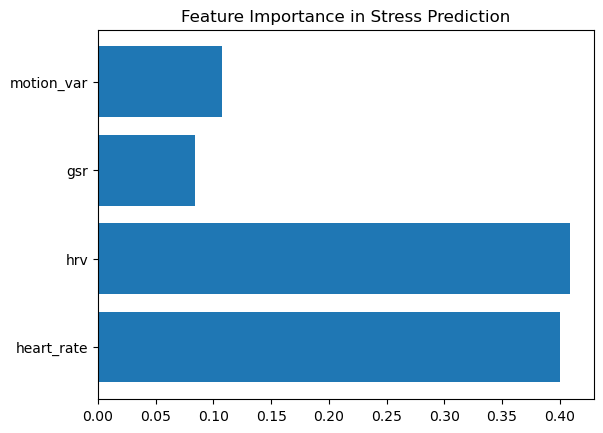


Adaptive thresholds per child: {'hr': 95, 'hrv': 31.499999999999996}


In [1]:
# SafeSchool_Wearable_AI - Stress Model Prototype
# ------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# ---------- 1. Simulate physiological data ----------
np.random.seed(42)
n = 600
df = pd.DataFrame({
    "heart_rate": np.random.normal(85, 15, n),
    "hrv": np.random.normal(40, 10, n),
    "gsr": np.random.normal(0.3, 0.1, n),
    "motion_var": np.random.normal(1.2, 0.4, n)
})

# Label generation (simple rule)
df["label"] = np.where((df.heart_rate > 100) & (df.hrv < 25) & (df.gsr > 0.35),
                       "Stress", "Normal")

# ---------- 2. Threshold / Rule-based AI ----------
def rule_based_stress(hr, hrv, gsr):
    if hr > 100 and hrv < 25 and gsr > 0.35:
        return "Stress"
    return "Normal"

df["rule_pred"] = df.apply(lambda x: rule_based_stress(x.heart_rate, x.hrv, x.gsr), axis=1)
print("Sample rule-based predictions:")
print(df.head(5)[["heart_rate","hrv","gsr","rule_pred"]])

# ---------- 3. ML Model (adaptive baseline trainer) ----------
X = df[["heart_rate","hrv","gsr","motion_var"]]
y = df["label"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

model = RandomForestClassifier(n_estimators=80, random_state=42)
model.fit(X_train,y_train)
preds = model.predict(X_test)

print("\nModel Accuracy:", accuracy_score(y_test,preds))
print(classification_report(y_test,preds))

# ---------- 4. Visualize feature importance ----------
plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance in Stress Prediction")
plt.show()

# ---------- 5. Adaptive Baseline Simulation ----------
child_baseline = {"heart_rate":80,"hrv":45}
adaptive_thresholds = {
    "hr": child_baseline["heart_rate"] + 15,
    "hrv": child_baseline["hrv"] * 0.7
}
print("\nAdaptive thresholds per child:", adaptive_thresholds)
